In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats
from tqdm import tqdm

2022-11-07 05:17:30.764832: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./cell_level-use_pretrain', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

19279
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=19279, save_dir='./cell_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=cell_level-use_pretrain, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 19279
save_dir         : ./cell_level-use_pretrain
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=50, current::epoch=0, iter=0.00, type=cosine, T-max=50, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
#     inputs, targets = inputs[:64], targets[:64] # smaller batches
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [8]:
supernet_weights = torch.load("./250ep_cosine_supernet_cell_wise.pth")
network.load_state_dict(supernet_weights)

<All keys matched successfully>

In [10]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(5):
    logger.log("arch loop#{}, current structure:".format(arch_loop))
    for m in search_model.modules():
        if isinstance(m, SearchCell):
            logger.log(m.arch_cache)
    for target_cell_idx in range(num_cells):
        target_cell = cells[target_cell_idx]
        print("\n\n Searching with a cell #{}".format(target_cell_idx))
        ## evaluation
        network.train()
        archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
        loader_iter = iter(valid_loader)
        for search_iter in tqdm(range(100)):
            ###### random gen
            genotypes = []
            for n in range(1, xargs.max_nodes):
                genotypes.append(random.choice(possible_connections[n]))
            arch = Structure(genotypes)
            target_cell.arch_cache = arch
#             arch = target_cell.random_genotype(True)
            ###### measure metrics
            try:
                inputs, targets = next(loader_iter)
            except:
                loader_iter = iter(valid_loader)
                inputs, targets = next(loader_iter)
            inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
            step_sim = step_sim_metric(network, criterion, inputs, targets)
            archs.append(arch)
            metric_accs.append(valid_acc)
            metric_confidences.append(confidence)
            metric_sensitivities.append(sensitivity)
            metric_robustnesses.append(robustness)
            metric_step_sims.append(step_sim)
        rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
        l = len(rank_accs)
        rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
#             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
        best_idx = np.argmax(rank_agg)
        best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
        logger.log("Found best op for target cell:{}".format(target_cell_idx))
        logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
        target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 24
target_node:3 124
arch loop#0, current structure:
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]

Found best op for target cell:0
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|none~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|) with accuracy=33.20%, confidence=13.822%, sensitivity=0.002, robustness=-0.001, step_sim=96.836


 Searching with a cell #1



100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

Found best op for target cell:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=40.23%, confidence=14.090%, sensitivity=0.002, robustness=-0.001, step_sim=97.678


 Searching with a cell #2



100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

Found best op for target cell:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=40.04%, confidence=14.287%, sensitivity=0.002, robustness=-0.001, step_sim=97.950


 Searching with a cell #3



100%|██████████| 100/100 [01:58<00:00,  1.19s/it]

Found best op for target cell:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|skip_connect~0|none~1|nor_conv_3x3~2|) with accuracy=41.21%, confidence=14.407%, sensitivity=0.002, robustness=-0.001, step_sim=98.165


 Searching with a cell #4



100%|██████████| 100/100 [02:01<00:00,  1.21s/it]

Found best op for target cell:4
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|none~2|) with accuracy=39.45%, confidence=14.417%, sensitivity=0.002, robustness=-0.001, step_sim=97.985


 Searching with a cell #5



100%|██████████| 100/100 [02:05<00:00,  1.26s/it]

Found best op for target cell:5
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=47.27%, confidence=16.783%, sensitivity=0.002, robustness=-0.001, step_sim=98.362


 Searching with a cell #6



100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

Found best op for target cell:6
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=50.59%, confidence=18.623%, sensitivity=0.003, robustness=-0.001, step_sim=98.297


 Searching with a cell #7



100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Found best op for target cell:7
: Structure(4 nodes with |skip_connect~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=54.49%, confidence=20.278%, sensitivity=0.004, robustness=-0.001, step_sim=97.758


 Searching with a cell #8



100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

Found best op for target cell:8
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|avg_pool_3x3~1|none~2|) with accuracy=54.49%, confidence=20.487%, sensitivity=0.004, robustness=-0.001, step_sim=97.435


 Searching with a cell #9



100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

Found best op for target cell:9
: Structure(4 nodes with |skip_connect~0|+|none~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=52.93%, confidence=20.535%, sensitivity=0.004, robustness=-0.001, step_sim=97.414


 Searching with a cell #10



100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

Found best op for target cell:10
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=42.351%, sensitivity=0.013, robustness=-0.004, step_sim=98.155


 Searching with a cell #11



100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Found best op for target cell:11
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=66.02%, confidence=48.702%, sensitivity=0.019, robustness=-0.007, step_sim=97.414


 Searching with a cell #12



100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:12
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=68.16%, confidence=51.747%, sensitivity=0.026, robustness=-0.008, step_sim=98.024


 Searching with a cell #13



100%|██████████| 100/100 [02:14<00:00,  1.34s/it]

Found best op for target cell:13
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=67.92%, confidence=54.698%, sensitivity=0.029, robustness=-0.009, step_sim=97.876


 Searching with a cell #14



100%|██████████| 100/100 [02:17<00:00,  1.37s/it]

Found best op for target cell:14
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=68.55%, confidence=56.562%, sensitivity=0.031, robustness=-0.010, step_sim=97.126
arch loop#1, current structure:
Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|none~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|none~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_3x3~


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:0
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|) with accuracy=66.80%, confidence=55.743%, sensitivity=0.024, robustness=-0.010, step_sim=96.876


 Searching with a cell #1



100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Found best op for target cell:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|) with accuracy=67.58%, confidence=56.721%, sensitivity=0.027, robustness=-0.008, step_sim=96.993


 Searching with a cell #2



100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|) with accuracy=67.97%, confidence=57.530%, sensitivity=0.037, robustness=-0.009, step_sim=97.024


 Searching with a cell #3



100%|██████████| 100/100 [02:21<00:00,  1.41s/it]

Found best op for target cell:3
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|) with accuracy=68.36%, confidence=57.213%, sensitivity=0.043, robustness=-0.012, step_sim=96.801


 Searching with a cell #4



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Found best op for target cell:4
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|none~2|) with accuracy=67.97%, confidence=56.195%, sensitivity=0.044, robustness=-0.012, step_sim=97.720


 Searching with a cell #5



100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Found best op for target cell:5
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=69.14%, confidence=56.956%, sensitivity=0.041, robustness=-0.008, step_sim=98.163


 Searching with a cell #6



100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Found best op for target cell:6
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=70.51%, confidence=57.317%, sensitivity=0.043, robustness=-0.010, step_sim=97.907


 Searching with a cell #7



100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Found best op for target cell:7
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|) with accuracy=71.09%, confidence=58.292%, sensitivity=0.045, robustness=-0.010, step_sim=97.674


 Searching with a cell #8



100%|██████████| 100/100 [02:21<00:00,  1.42s/it]

Found best op for target cell:8
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|none~2|) with accuracy=67.58%, confidence=56.727%, sensitivity=0.046, robustness=-0.013, step_sim=98.303


 Searching with a cell #9



100%|██████████| 100/100 [02:21<00:00,  1.42s/it]

Found best op for target cell:9
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=70.90%, confidence=57.986%, sensitivity=0.044, robustness=-0.012, step_sim=98.230


 Searching with a cell #10



100%|██████████| 100/100 [02:07<00:00,  1.28s/it]

Found best op for target cell:10
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=70.31%, confidence=56.852%, sensitivity=0.042, robustness=-0.010, step_sim=98.072


 Searching with a cell #11



100%|██████████| 100/100 [02:23<00:00,  1.44s/it]

Found best op for target cell:11
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|none~2|) with accuracy=68.16%, confidence=56.802%, sensitivity=0.044, robustness=-0.011, step_sim=97.970


 Searching with a cell #12



100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Found best op for target cell:12
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|none~2|) with accuracy=69.34%, confidence=57.048%, sensitivity=0.042, robustness=-0.012, step_sim=98.554


 Searching with a cell #13



100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:13
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|) with accuracy=67.77%, confidence=56.575%, sensitivity=0.047, robustness=-0.013, step_sim=98.337


 Searching with a cell #14



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Found best op for target cell:14
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|none~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=67.77%, confidence=55.253%, sensitivity=0.046, robustness=-0.012, step_sim=98.184
arch loop#2, current structure:
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|)
Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|none~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|avg_


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

Found best op for target cell:0
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=68.16%, confidence=56.810%, sensitivity=0.049, robustness=-0.015, step_sim=98.370


 Searching with a cell #1



100%|██████████| 100/100 [02:17<00:00,  1.37s/it]

Found best op for target cell:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|nor_conv_1x1~1|none~2|) with accuracy=69.14%, confidence=56.532%, sensitivity=0.042, robustness=-0.013, step_sim=98.308


 Searching with a cell #2



100%|██████████| 100/100 [02:17<00:00,  1.38s/it]

Found best op for target cell:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=70.31%, confidence=58.124%, sensitivity=0.040, robustness=-0.012, step_sim=98.128


 Searching with a cell #3



100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

Found best op for target cell:3
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=71.48%, confidence=58.234%, sensitivity=0.033, robustness=-0.010, step_sim=98.224


 Searching with a cell #4



100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Found best op for target cell:4
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=68.95%, confidence=56.719%, sensitivity=0.029, robustness=-0.009, step_sim=98.446


 Searching with a cell #5



100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Found best op for target cell:5
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|) with accuracy=70.70%, confidence=57.619%, sensitivity=0.031, robustness=-0.009, step_sim=98.252


 Searching with a cell #6



100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

Found best op for target cell:6
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_1x1~2|) with accuracy=67.58%, confidence=56.112%, sensitivity=0.033, robustness=-0.010, step_sim=98.190


 Searching with a cell #7



100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

Found best op for target cell:7
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|) with accuracy=69.34%, confidence=57.263%, sensitivity=0.037, robustness=-0.008, step_sim=97.856


 Searching with a cell #8



100%|██████████| 100/100 [02:13<00:00,  1.33s/it]

Found best op for target cell:8
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=70.51%, confidence=56.808%, sensitivity=0.032, robustness=-0.008, step_sim=98.051


 Searching with a cell #9



100%|██████████| 100/100 [02:14<00:00,  1.34s/it]

Found best op for target cell:9
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=70.70%, confidence=57.586%, sensitivity=0.032, robustness=-0.008, step_sim=98.006


 Searching with a cell #10



100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:10
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|none~2|) with accuracy=68.40%, confidence=56.739%, sensitivity=0.035, robustness=-0.010, step_sim=98.343


 Searching with a cell #11



100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Found best op for target cell:11
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=70.51%, confidence=56.896%, sensitivity=0.036, robustness=-0.009, step_sim=97.785


 Searching with a cell #12



100%|██████████| 100/100 [02:05<00:00,  1.25s/it]

Found best op for target cell:12
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=70.70%, confidence=55.473%, sensitivity=0.032, robustness=-0.009, step_sim=98.250


 Searching with a cell #13



100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Found best op for target cell:13
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|none~2|) with accuracy=68.75%, confidence=55.389%, sensitivity=0.033, robustness=-0.008, step_sim=98.508


 Searching with a cell #14



100%|██████████| 100/100 [02:07<00:00,  1.27s/it]

Found best op for target cell:14
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=68.75%, confidence=56.519%, sensitivity=0.036, robustness=-0.010, step_sim=98.586
arch loop#3, current structure:
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|nor_conv_1x1~1|none~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
Structure(4 nodes wit


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]

Found best op for target cell:0
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|none~2|) with accuracy=70.31%, confidence=57.165%, sensitivity=0.035, robustness=-0.009, step_sim=98.297


 Searching with a cell #1



100%|██████████| 100/100 [01:50<00:00,  1.11s/it]

Found best op for target cell:1
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=68.55%, confidence=56.211%, sensitivity=0.039, robustness=-0.008, step_sim=98.249


 Searching with a cell #2



100%|██████████| 100/100 [02:03<00:00,  1.23s/it]

Found best op for target cell:2
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=70.90%, confidence=58.606%, sensitivity=0.041, robustness=-0.010, step_sim=98.416


 Searching with a cell #3



100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

Found best op for target cell:3
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|skip_connect~2|) with accuracy=69.53%, confidence=57.060%, sensitivity=0.048, robustness=-0.011, step_sim=98.405


 Searching with a cell #4



100%|██████████| 100/100 [01:53<00:00,  1.14s/it]

Found best op for target cell:4
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|) with accuracy=69.73%, confidence=56.158%, sensitivity=0.054, robustness=-0.012, step_sim=98.110


 Searching with a cell #5



100%|██████████| 100/100 [02:09<00:00,  1.30s/it]

Found best op for target cell:5
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|none~1|avg_pool_3x3~2|) with accuracy=69.34%, confidence=57.799%, sensitivity=0.056, robustness=-0.014, step_sim=98.023


 Searching with a cell #6



100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

Found best op for target cell:6
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|none~1|skip_connect~2|) with accuracy=67.58%, confidence=57.306%, sensitivity=0.063, robustness=-0.015, step_sim=98.200


 Searching with a cell #7



100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

Found best op for target cell:7
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=65.82%, confidence=55.363%, sensitivity=0.059, robustness=-0.015, step_sim=98.557


 Searching with a cell #8



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Found best op for target cell:8
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=70.31%, confidence=57.332%, sensitivity=0.053, robustness=-0.012, step_sim=98.151


 Searching with a cell #9



100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Found best op for target cell:9
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=68.55%, confidence=56.407%, sensitivity=0.056, robustness=-0.010, step_sim=98.224


 Searching with a cell #10



100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Found best op for target cell:10
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=69.10%, confidence=56.677%, sensitivity=0.056, robustness=-0.012, step_sim=98.215


 Searching with a cell #11



100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

Found best op for target cell:11
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=68.36%, confidence=55.039%, sensitivity=0.052, robustness=-0.011, step_sim=98.102


 Searching with a cell #12



100%|██████████| 100/100 [02:26<00:00,  1.47s/it]

Found best op for target cell:12
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|none~2|) with accuracy=67.97%, confidence=54.376%, sensitivity=0.052, robustness=-0.011, step_sim=98.169


 Searching with a cell #13



100%|██████████| 100/100 [02:14<00:00,  1.35s/it]

Found best op for target cell:13
: Structure(4 nodes with |skip_connect~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=68.16%, confidence=56.464%, sensitivity=0.054, robustness=-0.013, step_sim=98.336


 Searching with a cell #14



100%|██████████| 100/100 [02:17<00:00,  1.38s/it]

Found best op for target cell:14
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|) with accuracy=68.36%, confidence=56.499%, sensitivity=0.054, robustness=-0.011, step_sim=98.473
arch loop#4, current structure:
Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|none~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|none~1|avg_pool_3x3~2|)
Structure(4 nodes with |avg_pool_3x3~0|+|skip


100%|██████████| 100/100 [02:31<00:00,  1.51s/it]

Found best op for target cell:0
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|none~2|) with accuracy=71.48%, confidence=58.477%, sensitivity=0.038, robustness=-0.011, step_sim=97.839


 Searching with a cell #1



100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

Found best op for target cell:1
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|none~1|skip_connect~2|) with accuracy=71.09%, confidence=58.664%, sensitivity=0.039, robustness=-0.010, step_sim=97.879


 Searching with a cell #2



100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Found best op for target cell:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|) with accuracy=70.31%, confidence=55.973%, sensitivity=0.038, robustness=-0.014, step_sim=98.014


 Searching with a cell #3



100%|██████████| 100/100 [02:13<00:00,  1.33s/it]

Found best op for target cell:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=68.36%, confidence=55.746%, sensitivity=0.038, robustness=-0.010, step_sim=97.953


 Searching with a cell #4



100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

Found best op for target cell:4
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=69.53%, confidence=57.036%, sensitivity=0.042, robustness=-0.010, step_sim=98.347


 Searching with a cell #5



100%|██████████| 100/100 [02:15<00:00,  1.36s/it]

Found best op for target cell:5
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|) with accuracy=70.31%, confidence=56.842%, sensitivity=0.039, robustness=-0.010, step_sim=98.351


 Searching with a cell #6



100%|██████████| 100/100 [02:22<00:00,  1.43s/it]

Found best op for target cell:6
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_conv_3x3~0|skip_connect~1|skip_connect~2|) with accuracy=67.58%, confidence=55.149%, sensitivity=0.043, robustness=-0.009, step_sim=98.145


 Searching with a cell #7



100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Found best op for target cell:7
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=68.75%, confidence=55.446%, sensitivity=0.046, robustness=-0.011, step_sim=98.443


 Searching with a cell #8



100%|██████████| 100/100 [02:24<00:00,  1.45s/it]

Found best op for target cell:8
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_1x1~2|) with accuracy=70.31%, confidence=56.996%, sensitivity=0.041, robustness=-0.012, step_sim=98.287


 Searching with a cell #9



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Found best op for target cell:9
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=68.16%, confidence=55.675%, sensitivity=0.040, robustness=-0.011, step_sim=97.887


 Searching with a cell #10



100%|██████████| 100/100 [02:15<00:00,  1.35s/it]

Found best op for target cell:10
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|) with accuracy=68.36%, confidence=56.218%, sensitivity=0.042, robustness=-0.010, step_sim=98.060


 Searching with a cell #11



100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Found best op for target cell:11
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|none~0|avg_pool_3x3~1|none~2|) with accuracy=69.53%, confidence=56.892%, sensitivity=0.045, robustness=-0.011, step_sim=98.177


 Searching with a cell #12



100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

Found best op for target cell:12
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|) with accuracy=67.58%, confidence=56.072%, sensitivity=0.048, robustness=-0.010, step_sim=97.738


 Searching with a cell #13



100%|██████████| 100/100 [02:22<00:00,  1.42s/it]

Found best op for target cell:13
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|) with accuracy=66.99%, confidence=54.959%, sensitivity=0.043, robustness=-0.012, step_sim=98.366


 Searching with a cell #14



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Found best op for target cell:14
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=66.99%, confidence=55.638%, sensitivity=0.049, robustness=-0.012, step_sim=97.989
Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|none~2|)
Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|none~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_conv_3x3~0|skip_

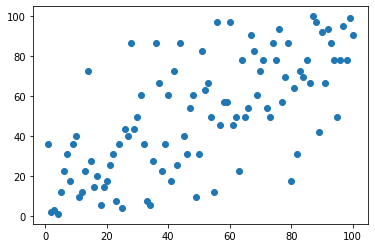

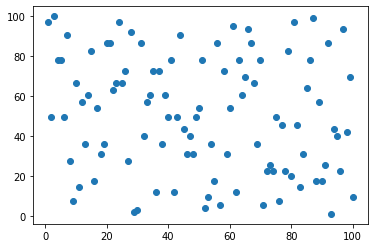

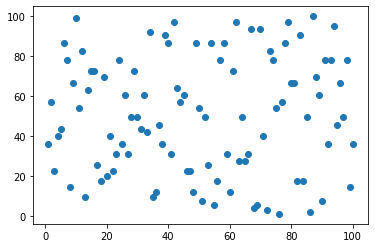

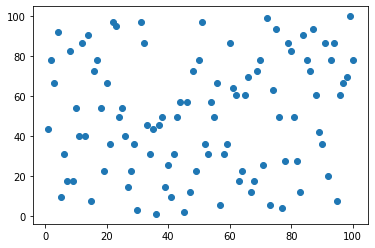

In [11]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [12]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=19279, save_dir='./cell_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=19279, save_dir='./cell_level-use_pretrain/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [13]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [14]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=cell_level-use_pretrain/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 19279
save_dir         : ./cell_level-use_pretrain/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim='SGD', LR=0.1, decay=0.0005, momentum=0.9, nesterov=True, criterion='Softma

In [15]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [16]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-07 08:23:48] [000-200][000/196] Time 0.39 (0.39) Data 0.18 (0.18) Base [Loss 2.344 (2.344)  Prec@1 12.89 (12.89) Prec@5 48.44 (48.44)]
*SEARCH* [2022-11-07 08:24:18] [000-200][195/196] Time 0.11 (0.16) Data 0.00 (0.00) Base [Loss 1.340 (1.649)  Prec@1 42.50 (38.27) Prec@5 93.75 (87.64)]
[000-200] searching : loss=1.65, accuracy@1=38.27%, accuracy@5=87.64%, time-cost=30.7 s
[000-200] evaluate  : loss=4.55, accuracy@1=20.77%, accuracy@5=72.89%
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 000-200-th epoch : find the highest validation accuracy : 20.77%.
copy the file from cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth into cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth

[Search the 001-200-th epoch] Time Left: [01:52:40], LR=0.09999383162408304
*SEARCH* [20

*SEARCH* [2022-11-07 08:28:28] [007-200][195/196] Time 0.21 (0.16) Data 0.00 (0.00) Base [Loss 0.769 (0.584)  Prec@1 72.50 (79.85) Prec@5 97.50 (98.90)]
[007-200] searching : loss=0.58, accuracy@1=79.85%, accuracy@5=98.90%, time-cost=255.2 s
[007-200] evaluate  : loss=0.89, accuracy@1=70.76%, accuracy@5=97.48%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 007-200-th epoch : find the highest validation accuracy : 70.76%.
Find cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth exist, delete is at first before saving
copy the file from cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth into cell_level-use_pretrain/train/checkpoint/seed-1927

*SEARCH* [2022-11-07 08:33:21] [016-200][000/196] Time 0.31 (0.31) Data 0.16 (0.16) Base [Loss 0.427 (0.427)  Prec@1 85.16 (85.16) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 08:33:51] [016-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.636 (0.466)  Prec@1 81.25 (84.00) Prec@5 98.75 (99.24)]
[016-200] searching : loss=0.47, accuracy@1=84.00%, accuracy@5=99.24%, time-cost=545.6 s
[016-200] evaluate  : loss=0.57, accuracy@1=80.64%, accuracy@5=99.10%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 016-200-th epoch : find the highest validation accuracy : 80.64%.
Find cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth exist, delete is at f

*SEARCH* [2022-11-07 08:38:41] [025-200][000/196] Time 0.45 (0.45) Data 0.22 (0.22) Base [Loss 0.443 (0.443)  Prec@1 84.77 (84.77) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 08:39:15] [025-200][195/196] Time 0.11 (0.18) Data 0.00 (0.00) Base [Loss 0.588 (0.417)  Prec@1 83.75 (85.75) Prec@5 100.00 (99.44)]
[025-200] searching : loss=0.42, accuracy@1=85.75%, accuracy@5=99.44%, time-cost=836.8 s
[025-200] evaluate  : loss=0.63, accuracy@1=79.05%, accuracy@5=98.96%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 026-200-th epoch] Time Left: [01:54:20], LR=0.09588773128419906
*SEARCH* [2022-11-07 08:39:20] [026-200][000/196] Time 0.39 (0.39) Data 0.22 (0.22) Base [L

*SEARCH* [2022-11-07 08:44:34] [034-200][195/196] Time 0.09 (0.17) Data 0.00 (0.00) Base [Loss 0.187 (0.395)  Prec@1 95.00 (86.40) Prec@5 100.00 (99.50)]
[034-200] searching : loss=0.40, accuracy@1=86.40%, accuracy@5=99.50%, time-cost=1122.2 s
[034-200] evaluate  : loss=0.67, accuracy@1=77.85%, accuracy@5=99.14%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 035-200-th epoch] Time Left: [01:41:57], LR=0.09263200821770462
*SEARCH* [2022-11-07 08:44:39] [035-200][000/196] Time 0.37 (0.37) Data 0.18 (0.18) Base [Loss 0.383 (0.383)  Prec@1 86.33 (86.33) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 08:45:10] [035-200][195/196] Time 0.16 (0.16) Data 0.00 (0.00) Base [

*SEARCH* [2022-11-07 08:49:47] [043-200][195/196] Time 0.12 (0.15) Data 0.00 (0.00) Base [Loss 0.327 (0.366)  Prec@1 87.50 (87.43) Prec@5 98.75 (99.59)]
[043-200] searching : loss=0.37, accuracy@1=87.43%, accuracy@5=99.59%, time-cost=1402.8 s
[043-200] evaluate  : loss=0.56, accuracy@1=81.63%, accuracy@5=99.08%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 043-200-th epoch : find the highest validation accuracy : 81.63%.
Find cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth exist, delete is at first before saving
copy the file from cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth into cell_level-use_pretrain/train/checkpoint/seed-192

*SEARCH* [2022-11-07 08:54:40] [052-200][000/196] Time 0.46 (0.46) Data 0.23 (0.23) Base [Loss 0.361 (0.361)  Prec@1 89.06 (89.06) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 08:55:12] [052-200][195/196] Time 0.11 (0.16) Data 0.00 (0.00) Base [Loss 0.417 (0.344)  Prec@1 83.75 (88.19) Prec@5 100.00 (99.64)]
[052-200] searching : loss=0.34, accuracy@1=88.19%, accuracy@5=99.64%, time-cost=1694.3 s
[052-200] evaluate  : loss=0.68, accuracy@1=78.02%, accuracy@5=98.61%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 053-200-th epoch] Time Left: [01:25:49], LR=0.08365062567548867
*SEARCH* [2022-11-07 08:55:15] [053-200][000/196] Time 0.32 (0.32) Data 0.16 (0.16) Base [

*SEARCH* [2022-11-07 08:59:54] [061-200][000/196] Time 0.53 (0.53) Data 0.19 (0.19) Base [Loss 0.303 (0.303)  Prec@1 90.62 (90.62) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:00:25] [061-200][195/196] Time 0.08 (0.16) Data 0.00 (0.00) Base [Loss 0.409 (0.324)  Prec@1 87.50 (88.90) Prec@5 97.50 (99.69)]
[061-200] searching : loss=0.32, accuracy@1=88.90%, accuracy@5=99.69%, time-cost=1976.4 s
[061-200] evaluate  : loss=0.58, accuracy@1=81.18%, accuracy@5=99.29%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 062-200-th epoch] Time Left: [01:20:43], LR=0.07810416889260655
*SEARCH* [2022-11-07 09:00:29] [062-200][000/196] Time 0.35 (0.35) Data 0.22 (0.22) Base 

[069-200] evaluate  : loss=0.53, accuracy@1=83.05%, accuracy@5=98.84%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 070-200-th epoch] Time Left: [01:16:45], LR=0.07269952498697733
*SEARCH* [2022-11-07 09:05:11] [070-200][000/196] Time 0.29 (0.29) Data 0.17 (0.17) Base [Loss 0.243 (0.243)  Prec@1 92.58 (92.58) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:05:41] [070-200][195/196] Time 0.08 (0.15) Data 0.00 (0.00) Base [Loss 0.421 (0.310)  Prec@1 86.25 (89.29) Prec@5 100.00 (99.68)]
[070-200] searching : loss=0.31, accuracy@1=89.29%, accuracy@5=99.68%, time-cost=2257.5 s
[070-200] evaluate  : loss=0.59, accuracy@1=80.65%, accuracy@5=98.90%
Find cell_level-use_

[078-200] evaluate  : loss=0.67, accuracy@1=79.14%, accuracy@5=98.76%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 079-200-th epoch] Time Left: [01:15:15], LR=0.06619587090990747
*SEARCH* [2022-11-07 09:10:33] [079-200][000/196] Time 0.36 (0.36) Data 0.17 (0.17) Base [Loss 0.241 (0.241)  Prec@1 91.02 (91.02) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:11:03] [079-200][195/196] Time 0.16 (0.16) Data 0.00 (0.00) Base [Loss 0.316 (0.294)  Prec@1 88.75 (89.80) Prec@5 98.75 (99.75)]
[079-200] searching : loss=0.29, accuracy@1=89.80%, accuracy@5=99.75%, time-cost=2546.9 s
[079-200] evaluate  : loss=0.49, accuracy@1=83.56%, accuracy@5=99.35%
Find cell_level-use

[087-200] evaluate  : loss=0.54, accuracy@1=82.47%, accuracy@5=98.94%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 088-200-th epoch] Time Left: [01:03:12], LR=0.05936906572928624
*SEARCH* [2022-11-07 09:15:51] [088-200][000/196] Time 0.39 (0.39) Data 0.18 (0.18) Base [Loss 0.228 (0.228)  Prec@1 92.58 (92.58) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:16:23] [088-200][195/196] Time 0.23 (0.17) Data 0.00 (0.00) Base [Loss 0.252 (0.269)  Prec@1 91.25 (90.54) Prec@5 100.00 (99.79)]
[088-200] searching : loss=0.27, accuracy@1=90.54%, accuracy@5=99.79%, time-cost=2833.1 s
[088-200] evaluate  : loss=0.45, accuracy@1=84.90%, accuracy@5=99.53%
Find cell_level-use_

*SEARCH* [2022-11-07 09:19:58] [095-200][000/196] Time 0.32 (0.32) Data 0.20 (0.20) Base [Loss 0.295 (0.295)  Prec@1 91.80 (91.80) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:20:29] [095-200][195/196] Time 0.19 (0.16) Data 0.00 (0.00) Base [Loss 0.292 (0.256)  Prec@1 88.75 (91.12) Prec@5 100.00 (99.81)]
[095-200] searching : loss=0.26, accuracy@1=91.12%, accuracy@5=99.81%, time-cost=3049.5 s
[095-200] evaluate  : loss=0.60, accuracy@1=82.04%, accuracy@5=98.80%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 096-200-th epoch] Time Left: [01:00:40], LR=0.05313952597646568
*SEARCH* [2022-11-07 09:20:33] [096-200][000/196] Time 0.47 (0.47) Data 0.24 (0.24) Base

*SEARCH* [2022-11-07 09:25:49] [104-200][195/196] Time 0.12 (0.16) Data 0.00 (0.00) Base [Loss 0.187 (0.238)  Prec@1 93.75 (91.64) Prec@5 100.00 (99.85)]
[104-200] searching : loss=0.24, accuracy@1=91.64%, accuracy@5=99.85%, time-cost=3334.7 s
[104-200] evaluate  : loss=0.41, accuracy@1=86.92%, accuracy@5=99.41%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 105-200-th epoch] Time Left: [00:55:36], LR=0.04607704521360776
*SEARCH* [2022-11-07 09:25:53] [105-200][000/196] Time 0.35 (0.35) Data 0.16 (0.16) Base [Loss 0.240 (0.240)  Prec@1 91.41 (91.41) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:26:27] [105-200][195/196] Time 0.11 (0.17) Data 0.00 (0.00) Base

*SEARCH* [2022-11-07 09:31:11] [113-200][195/196] Time 0.14 (0.17) Data 0.00 (0.00) Base [Loss 0.189 (0.215)  Prec@1 91.25 (92.57) Prec@5 100.00 (99.87)]
[113-200] searching : loss=0.22, accuracy@1=92.57%, accuracy@5=99.87%, time-cost=3620.2 s
[113-200] evaluate  : loss=0.54, accuracy@1=84.15%, accuracy@5=99.24%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 114-200-th epoch] Time Left: [00:55:06], LR=0.03909283793017289
*SEARCH* [2022-11-07 09:31:16] [114-200][000/196] Time 0.40 (0.40) Data 0.24 (0.24) Base [Loss 0.233 (0.233)  Prec@1 92.97 (92.97) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:31:46] [114-200][195/196] Time 0.19 (0.16) Data 0.00 (0.00) Base

*SEARCH* [2022-11-07 09:35:57] [122-200][000/196] Time 0.36 (0.36) Data 0.16 (0.16) Base [Loss 0.194 (0.194)  Prec@1 92.58 (92.58) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:36:28] [122-200][195/196] Time 0.17 (0.16) Data 0.00 (0.00) Base [Loss 0.412 (0.191)  Prec@1 86.25 (93.41) Prec@5 98.75 (99.89)]
[122-200] searching : loss=0.19, accuracy@1=93.41%, accuracy@5=99.89%, time-cost=3903.0 s
[122-200] evaluate  : loss=0.41, accuracy@1=87.34%, accuracy@5=99.52%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 123-200-th epoch] Time Left: [00:46:10], LR=0.03232625781103715
*SEARCH* [2022-11-07 09:36:33] [123-200][000/196] Time 0.35 (0.35) Data 0.19 (0.19) Base 

*SEARCH* [2022-11-07 09:41:16] [131-200][000/196] Time 0.45 (0.45) Data 0.18 (0.18) Base [Loss 0.115 (0.115)  Prec@1 96.09 (96.09) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:41:49] [131-200][195/196] Time 0.08 (0.17) Data 0.00 (0.00) Base [Loss 0.216 (0.158)  Prec@1 93.75 (94.49) Prec@5 100.00 (99.93)]
[131-200] searching : loss=0.16, accuracy@1=94.49%, accuracy@5=99.93%, time-cost=4188.0 s
[131-200] evaluate  : loss=0.40, accuracy@1=87.90%, accuracy@5=99.39%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 132-200-th epoch] Time Left: [00:41:31], LR=0.02591231629491423
*SEARCH* [2022-11-07 09:41:53] [132-200][000/196] Time 0.35 (0.35) Data 0.22 (0.22) Base

*SEARCH* [2022-11-07 09:46:38] [140-200][000/196] Time 0.33 (0.33) Data 0.17 (0.17) Base [Loss 0.099 (0.099)  Prec@1 98.05 (98.05) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:47:10] [140-200][195/196] Time 0.15 (0.17) Data 0.00 (0.00) Base [Loss 0.261 (0.133)  Prec@1 91.25 (95.43) Prec@5 100.00 (99.95)]
[140-200] searching : loss=0.13, accuracy@1=95.43%, accuracy@5=99.95%, time-cost=4476.8 s
[140-200] evaluate  : loss=0.38, accuracy@1=88.48%, accuracy@5=99.55%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 140-200-th epoch : find the highest validation accuracy : 88.48%.
Find cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth exist, delete is at

*SEARCH* [2022-11-07 09:51:25] [148-200][000/196] Time 0.39 (0.39) Data 0.17 (0.17) Base [Loss 0.103 (0.103)  Prec@1 95.31 (95.31) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:51:59] [148-200][195/196] Time 0.11 (0.18) Data 0.00 (0.00) Base [Loss 0.115 (0.112)  Prec@1 96.25 (96.13) Prec@5 100.00 (99.96)]
[148-200] searching : loss=0.11, accuracy@1=96.13%, accuracy@5=99.96%, time-cost=4734.9 s
[148-200] evaluate  : loss=0.33, accuracy@1=89.80%, accuracy@5=99.68%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth
<<<--->>> The 148-200-th epoch : find the highest validation accuracy : 89.80%.
Find cell_level-use_pretrain/train/checkpoint/seed-19279-best.pth exist, delete is at

*SEARCH* [2022-11-07 09:56:14] [156-200][000/196] Time 0.43 (0.43) Data 0.23 (0.23) Base [Loss 0.076 (0.076)  Prec@1 97.27 (97.27) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:56:45] [156-200][195/196] Time 0.15 (0.16) Data 0.00 (0.00) Base [Loss 0.062 (0.081)  Prec@1 98.75 (97.26) Prec@5 100.00 (99.99)]
[156-200] searching : loss=0.08, accuracy@1=97.26%, accuracy@5=99.99%, time-cost=4991.7 s
[156-200] evaluate  : loss=0.35, accuracy@1=89.94%, accuracy@5=99.75%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 157-200-th epoch] Time Left: [00:25:47], LR=0.010978479633083522
*SEARCH* [2022-11-07 09:56:50] [157-200][000/196] Time 0.39 (0.39) Data 0.20 (0.20) Bas

[164-200] evaluate  : loss=0.36, accuracy@1=90.65%, accuracy@5=99.67%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 165-200-th epoch] Time Left: [00:21:45], LR=0.007367991782295403
*SEARCH* [2022-11-07 10:01:40] [165-200][000/196] Time 0.31 (0.31) Data 0.18 (0.18) Base [Loss 0.044 (0.044)  Prec@1 98.05 (98.05) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:02:12] [165-200][195/196] Time 0.11 (0.16) Data 0.00 (0.00) Base [Loss 0.068 (0.049)  Prec@1 97.50 (98.43) Prec@5 100.00 (99.99)]
[165-200] searching : loss=0.05, accuracy@1=98.43%, accuracy@5=99.99%, time-cost=5282.6 s
[165-200] evaluate  : loss=0.35, accuracy@1=90.51%, accuracy@5=99.74%
Find cell_level-u

*SEARCH* [2022-11-07 10:05:50] [172-200][000/196] Time 0.35 (0.35) Data 0.16 (0.16) Base [Loss 0.046 (0.046)  Prec@1 98.83 (98.83) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:06:22] [172-200][195/196] Time 0.10 (0.17) Data 0.00 (0.00) Base [Loss 0.050 (0.031)  Prec@1 98.75 (99.11) Prec@5 100.00 (100.00)]
[172-200] searching : loss=0.03, accuracy@1=99.11%, accuracy@5=100.00%, time-cost=5504.8 s
[172-200] evaluate  : loss=0.34, accuracy@1=91.31%, accuracy@5=99.72%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 173-200-th epoch] Time Left: [00:16:13], LR=0.004429836168227746
*SEARCH* [2022-11-07 10:06:26] [173-200][000/196] Time 0.35 (0.35) Data 0.19 (0.19) B

*SEARCH* [2022-11-07 10:10:37] [180-200][000/196] Time 0.37 (0.37) Data 0.21 (0.21) Base [Loss 0.019 (0.019)  Prec@1 99.22 (99.22) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:11:07] [180-200][195/196] Time 0.20 (0.15) Data 0.00 (0.00) Base [Loss 0.073 (0.019)  Prec@1 96.25 (99.53) Prec@5 100.00 (100.00)]
[180-200] searching : loss=0.02, accuracy@1=99.53%, accuracy@5=100.00%, time-cost=5760.6 s
[180-200] evaluate  : loss=0.32, accuracy@1=91.83%, accuracy@5=99.75%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 181-200-th epoch] Time Left: [00:10:54], LR=0.002210349260083494
*SEARCH* [2022-11-07 10:11:12] [181-200][000/196] Time 0.37 (0.37) Data 0.22 (0.22) B

[188-200] evaluate  : loss=0.32, accuracy@1=92.09%, accuracy@5=99.70%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 189-200-th epoch] Time Left: [00:06:17], LR=0.0007445336922613067
*SEARCH* [2022-11-07 10:15:54] [189-200][000/196] Time 0.38 (0.38) Data 0.18 (0.18) Base [Loss 0.008 (0.008)  Prec@1 100.00 (100.00) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:16:27] [189-200][195/196] Time 0.11 (0.17) Data 0.00 (0.00) Base [Loss 0.035 (0.013)  Prec@1 98.75 (99.74) Prec@5 100.00 (100.00)]
[189-200] searching : loss=0.01, accuracy@1=99.74%, accuracy@5=100.00%, time-cost=6045.4 s
[189-200] evaluate  : loss=0.32, accuracy@1=92.12%, accuracy@5=99.68%
Find cell_le

[197-200] evaluate  : loss=0.32, accuracy@1=92.02%, accuracy@5=99.70%
Find cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/checkpoint/seed-19279-basic.pth
Find cell_level-use_pretrain/train/seed-19279-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-use_pretrain/train/seed-19279-last-info.pth

[Search the 198-200-th epoch] Time Left: [00:01:10], LR=2.467198171342e-05
*SEARCH* [2022-11-07 10:21:17] [198-200][000/196] Time 0.30 (0.30) Data 0.18 (0.18) Base [Loss 0.011 (0.011)  Prec@1 99.61 (99.61) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:21:49] [198-200][195/196] Time 0.18 (0.16) Data 0.00 (0.00) Base [Loss 0.028 (0.011)  Prec@1 100.00 (99.79) Prec@5 100.00 (100.00)]
[198-200] searching : loss=0.01, accuracy@1=99.79%, accuracy@5=100.00%, time-cost=6333.6 s
[198-200] evaluate  : loss=0.32, accuracy@1=92.06%, accuracy@5=99.74%
Find cell_level-

In [ ]:
best_archs